In [1]:
import os
if "datasets.ipynb" in os.listdir():
    os.chdir("../")
print("Running in {}".format(os.getcwd()))

Running in /data/hpcdata/users/anddon76/icenet/icenet-experimental


# datasets.ipynb

In this notebook, we create datasets for experimentation with different backbone models.

## 1. Single-Year Dataset

In [6]:
import pandas as pd
processing_dates = dict(
    train=[pd.to_datetime(el) for el in pd.date_range("2020-01-01", "2020-10-31")],
    val=[pd.to_datetime(el) for el in pd.date_range("2020-11-01", "2020-11-30")],
    test=[pd.to_datetime(el) for el in pd.date_range("2020-12-01", "2020-12-31")],
)
processed_name = "single_year"

In [7]:
from icenet.data.processors.era5 import IceNetERA5PreProcessor
from icenet.data.processors.meta import IceNetMetaPreProcessor
from icenet.data.processors.osi import IceNetOSIPreProcessor

pp = IceNetERA5PreProcessor(
    ["uas", "vas"],
    ["tas", "zg500", "zg250"],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)
osi = IceNetOSIPreProcessor(
    ["siconca"],
    [],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)
meta = IceNetMetaPreProcessor(
    processed_name,
    north=False,
    south=True
)

In [8]:
pp.init_source_data(
    lag_days=1,
)
pp.process()
osi.init_source_data(
    lag_days=1,
)
osi.process()
meta.process()

/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## 2. Single Day Dataset for Overfitting

In [2]:
import pandas as pd
processing_dates = dict(
    train=[pd.to_datetime(el) for el in pd.date_range("2020-01-01", "2020-01-01")],
    val=[pd.to_datetime(el) for el in pd.date_range("2020-01-01", "2020-01-01")],
    test=[pd.to_datetime(el) for el in pd.date_range("2020-01-01", "2020-01-01")],
)
processed_name = "single_day"

In [3]:
from icenet.data.processors.era5 import IceNetERA5PreProcessor
from icenet.data.processors.meta import IceNetMetaPreProcessor
from icenet.data.processors.osi import IceNetOSIPreProcessor

pp = IceNetERA5PreProcessor(
    ["uas", "vas"],
    ["tas", "zg500", "zg250"],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)
osi = IceNetOSIPreProcessor(
    ["siconca"],
    [],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)
meta = IceNetMetaPreProcessor(
    processed_name,
    north=False,
    south=True
)
pp.init_source_data(
    lag_days=1,
)
pp.process()
osi.init_source_data(
    lag_days=1,
)
osi.process()
meta.process()

2024-05-02 11:28:32.738113: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 11:28:32.787764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 11:28:32.787807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 11:28:32.789130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 11:28:32.799018: I tensorflow/core/platform/cpu_feature_guar

In [4]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.single_day.json"
dataset_name = "single_day"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=1,
    north=False,
    south=True,
    output_batch_size=1,
    generate_workers=1
)
dl.generate()

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39868 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-wxazdi46', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-tez0jxb9', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-q_ki80o0', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:36126
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:39868/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:dis

In [5]:
x, y, sw = dl.generate_sample(pd.Timestamp("2020-12-01"))
x.shape, y.shape, sw.shape

((432, 432, 9), (432, 432, 1, 1), (432, 432, 1, 1))

In [6]:
x.shape

(432, 432, 9)

47.519836


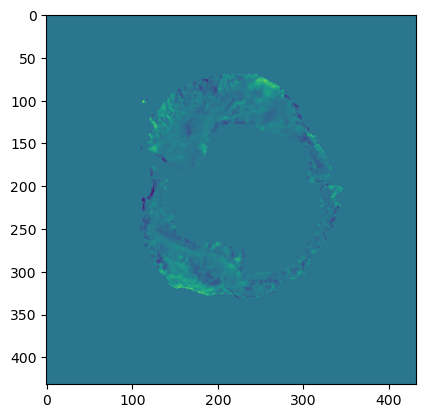

In [9]:
import numpy as np
import matplotlib.pyplot as plt
diff = x[:, :, 2] - y.squeeze()
print(np.sum(diff**2))
plt.imshow(diff)
plt.show()

In [17]:
import xarray as xr
xr.open_dataset("./processed/single_day/osisaf/south/siconca/siconca_abs.nc")

<xarray.Dataset>
Dimensions:      (time: 731, yc: 432, xc: 432)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2020-12-31
  * yc           (yc) float64 5.388e+06 5.362e+06 ... -5.362e+06 -5.388e+06
  * xc           (xc) float64 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
Data variables:
    siconca_abs  (time, yc, xc) float64 ...

## n. Test Dataset with Dataloader

In [6]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.single_day.json"
dataset_name = "single_day"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=1,
    north=False,
    south=True,
    output_batch_size=1,
    generate_workers=1
)

In [7]:
dl.generate()

/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44005 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:40790
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:44005/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35195'


INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:36685', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36685
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:39216
INFO:distributed.scheduler:Receive client connection: Client-871ffa06-07c4-11ef-b1d8-c4cbe1af5a66
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:39218
2024-05-01 15:10:14.351793: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 15:10:14.437761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 15:10:14.437813: 

In [8]:
x, y, sw = dl.generate_sample(pd.Timestamp("2020-01-01"))
x.shape, y.shape, sw.shape

((432, 432, 9), (432, 432, 1, 1), (432, 432, 1, 1))

## n+1: Test PyTorch Dataset Implementation

In [13]:
from utils import IceNetDataSetPyTorch
implementation = "dask"
dataset_config = "dataset_config.single_year.json"
dataset_name = "single_year"
lag = 1
train_ds = IceNetDataSetPyTorch(dataset_config, "train", batch_size=4, shuffling=True)
val_ds = IceNetDataSetPyTorch(dataset_config, "val", batch_size=4, shuffling=False)
test_ds = IceNetDataSetPyTorch(dataset_config, "test", batch_size=4, shuffling=False)

In [14]:
x, y, sw = train_ds[0]
x.shape, y.shape, sw.shape

(torch.Size([9, 432, 432]),
 torch.Size([30, 432, 432]),
 torch.Size([30, 432, 432]))

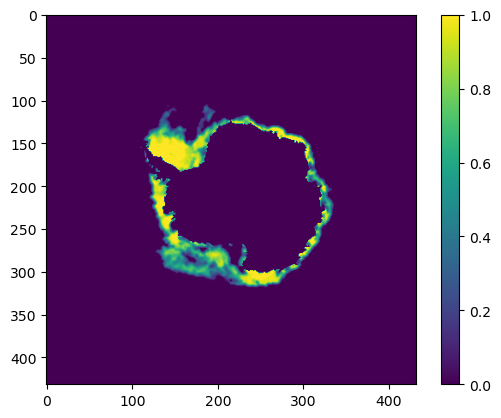

In [17]:
import matplotlib.pyplot as plt
plt.imshow(y[0, :, :].detach().numpy())
plt.colorbar()
plt.show()